In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
def create_df(effect=0.5, n_subs=20, n_trials=100, sigma_sub=1, sigma=1):
    """ Randomly generate a DataFrame containing Stroop-like data. """     
    n_cond_trials = n_subs * n_trials

    # fixed effect of condition
    y = np.repeat([0, effect], n_cond_trials)

    # subject effect
    cov = np.array([[sigma_sub, 0.7], [0.7, sigma_sub]])
    mu_sub = np.random.multivariate_normal([0, 0], cov, n_subs).T.ravel()
    y += np.repeat(mu_sub, len(y) / len(mu_sub))

    # error
    y += np.random.normal(0, sigma, len(y))

    # return as DF
    return pd.DataFrame({
        'condition': np.repeat([0, 1], n_cond_trials),
        'subject': np.tile(np.repeat(np.arange(n_subs), n_trials), 2),
        'trial': np.tile(np.tile(np.arange(n_trials), n_subs), 2),
        'y': y
    })

In [14]:
def fit_random_model(df, n_subs, draws=1000, **kwargs):
    """ Estimate a random-effects model in PyMC3 """
    with pm.Model() as model:
        b_intercept = pm.Normal('intercept', mu=0, sd=1)
        b_condition = pm.Normal('condition', mu=0, sd=1)
        u_intercept_sigma = pm.HalfNormal('subject_intercept_sigma', 2)
        u_intercept = pm.Normal('subject_intercept', mu=0, sd=u_intercept_sigma, shape=n_subs)
        u_condition_sigma = pm.HalfNormal('subject_condition_sigma', 2)
        u_condition = pm.Normal('subject_condition', mu=0, sd=u_condition_sigma, shape=n_subs)
        mu = (b_intercept + b_condition * df['condition'] + u_intercept[df['subject']] + 
              u_condition[df['subject']] * df['condition'])
        sigma = pm.HalfNormal('sigma', 2)
        y_hat = pm.Normal('y_hat', mu, sigma, observed=df['y'])

    with model:
        return pm.sample(draws=draws, **kwargs)


def fit_fixed_model(df, draws=1000, **kwargs):
    """ Estimate a fixed-effects model in PyMC3 """
    with pm.Model() as model:
        b_intercept = pm.Normal('intercept', mu=0, sd=1)
        b_condition = pm.Normal('condition', mu=0, sd=1)
        mu = b_intercept + b_condition * df['condition']
        sigma = pm.HalfNormal('sigma', 2)
        y_hat = pm.Normal('y_hat', mu, sigma, observed=df['y'])

    with model:
        return pm.sample(draws=draws, **kwargs)

In [16]:
# Simulation settings
N_REPS = 20
N_DRAWS = 1000
N_SUBS = 20

# Placeholder for random and fixed traces
random_traces = []
fixed_traces = []

# Sample!
for i in range(N_REPS):
    df = create_df(n_subs=N_SUBS)
    random_traces.append(fit_random_model(df, N_SUBS, N_DRAWS))
    fixed_traces.append(fit_fixed_model(df, N_DRAWS))

/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: 

Sampling 4 chains: 100%|██████████| 6000/6000 [01:31<00:00, 65.28draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, condition, intercept]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2371.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, subject_condition, subject_condition_sigma, subject_intercept, subject_intercept_sigma, condition, intercept]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:30<00:00, 66.46draws/s]
The acceptance probability does not match the target. It is 0.8943469864787472, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8871176702558866, but should be close to 0.8. Try to increase the number of tuning steps.
T

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, condition, intercept]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2192.40draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, subject_condition, subject_condition_sigma, subject_intercept, subject_intercept_sigma, condition, intercept]
Sampling 4 chains: 100%|██████████| 6000/6000 [1:01:54<00:00, 15.10draws/s]   
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, condition, intercept]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2425.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, subject_co

In [17]:
def get_estimates(traces):
    """ Extract just the mean and 95% HPD as a DF """
    bounds = []
    for i in range(N_REPS):
        summary = pm.summary(traces[i])
        lb = summary.loc['condition', 'hpd_2.5']
        ub = summary.loc['condition', 'hpd_97.5']
        est = summary.loc['condition', 'mean']
        bounds.append((est, lb, ub))
    return pd.DataFrame(bounds, columns=['mean', 'hpd_2.5', 'hpd_97.5'])

In [51]:
def plot_estimates(df, ax=None, title='', left_ax=False):
    """ Generate forest plots of effects """
    if ax is None:
        ax = plt.figure().gca()
    df = df.sort_values('mean')
    y = np.arange(N_REPS) + 0.5
    xerr = (df.loc[:, ['hpd_2.5', 'hpd_97.5']].apply(lambda x: x - df['mean'])).values
    xerr[:, 0] = np.abs(xerr[:, 0])
    ax.errorbar(df['mean'], y, xerr=xerr.T, fmt='o', color='k', capsize=4, capthick=1)
    ax.set_ylim(0, N_REPS)
    ax.grid(axis='x', linestyle='--')
    ax.grid(False, axis='y')
    ax.set_yticks(y, False)
    ax.set_yticklabels((y + 0.5).astype(int))
    ax.set_title(title, fontsize=18)
    if left_ax:
        ax.set_ylabel("Experiment", fontsize=16)
    ax.set_xlabel("Estimated Stroop effect", fontsize=16)

In [18]:
# Collect the random and fixed estimate DFs
random_ests = get_estimates(random_traces)
fixed_ests = get_estimates(fixed_traces)

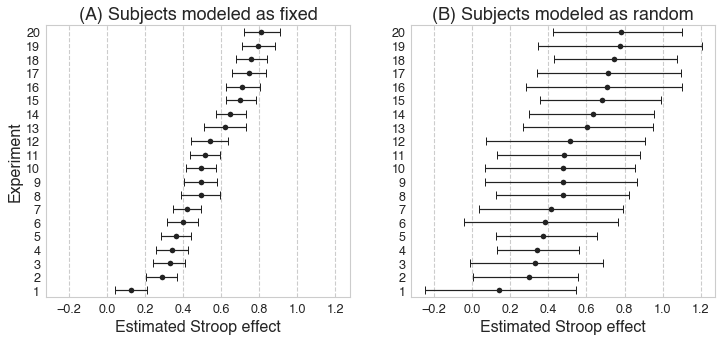

In [53]:
# Generate plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
plot_estimates(fixed_ests, axes[0], "(A) Subjects modeled as fixed", left_ax=True)
plot_estimates(random_ests, axes[1], "(B) Subjects modeled as random")
plt.tight_layout
# Uncomment next line to save
# plt.savefig('../figures/Figure1', dpi=200, bbox_inches='tight')